In [1]:
import sys
sys.path.insert(1, '../') # make sure to use the code in this repo

import matplotlib.dates as mdates
import datetime
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as fits
import scipy
import matplotlib as mpl
# try to use the precise epoch
mpl.rcParams['date.epoch']='1970-01-01T00:00:00'
try:
    mdates.set_epoch('1970-01-01T00:00:00')
except:
    pass

import detectRadioburst as drb

from skimage.transform import probabilistic_hough_line

%load_ext autoreload
%autoreload 2

In [2]:
fname  = 'L857852_SAP000_B000_S0_P000_bf/LOFAR_20220413_095000_LBA_OUTER.fits'
fname  = 'L857852_SAP000_B000_S0_P000_bf/LOFAR_20220413_135000_LBA_OUTER.fits'
#fname  = 'L857852_SAP000_B000_S0_P000_bf/LOFAR_20220413_150000_LBA_OUTER.fits'
#fname  = 'L857852_SAP000_B000_S0_P000_bf/LOFAR_20220413_103000_LBA_OUTER.fits'

(dyspec,t_fits,f_fits,hdu)  = drb.read_fits(fname)
(dyspec,f_fits) =  drb.cut_low(dyspec,f_fits,f_low_cut_val=25)

In [3]:
drb.idx_val_pos(f_fits, 25)

0

Text(0.5, 1.0, '2022/04/13 Radio Flux Intensity LOFAR LBA_OUTER')

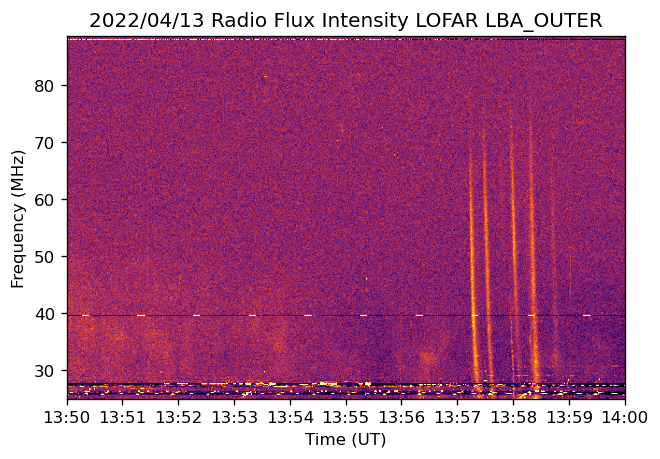

In [4]:
(data_fits_new_tmp,data_fits_new) = drb.preproc(
        dyspec,gauss_sigma=1.5)

fig = plt.figure(figsize=(6, 4), dpi=120)
ax = plt.gca()
ax.imshow(data_fits_new_tmp.T,aspect='auto',  origin='lower', 
                   vmin=(np.mean(data_fits_new_tmp)-2*np.std(data_fits_new_tmp)),
                   vmax=(np.mean(data_fits_new_tmp)+3*np.std(data_fits_new_tmp)),
                   extent=[t_fits[0],t_fits[-1],f_fits[0],f_fits[-1]],cmap='inferno')

ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(hdu[0].header['CONTENT'])

## Binarization Local max 

Threshold: $$I> I_{thresh}$$

Local-max: $$ I_{i-1}< I_{i}> I_{i+1} $$

Second order Local-max: $$ I_{i-2}< I_{i-1}< I_{i}> I_{i+1}> I_{i+2} $$

Second order Local-max with ratio R=1.2: $$ R^2 \times I_{i-2}< R \times I_{i-1}< I_{i}> R\times I_{i+1}> R^2 \times I_{i+2} $$


In [5]:
# binarization
bmap = drb.binarization(data_fits_new,N_order=6,peak_r=1.01)

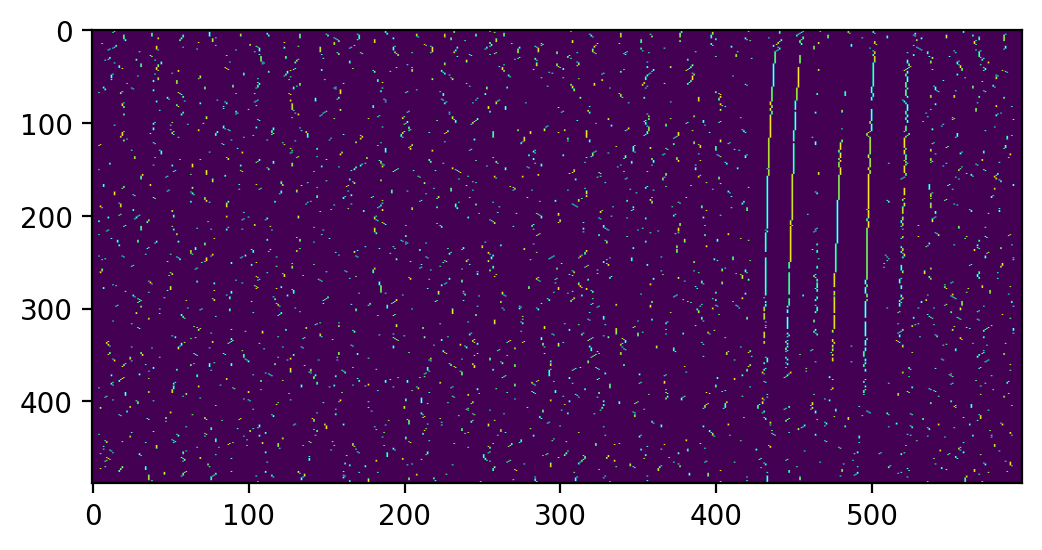

In [6]:
fig,ax = plt.subplots(1,1,figsize=[6,3],dpi=200)
ax.imshow(bmap.T,aspect='auto')

In [7]:
# detect verticle features
lines = drb.hough_detect(bmap,dyspec,threshold=60,line_gap=10,line_length=25,
            theta=np.linspace(np.pi/2-np.pi/8,np.pi/2-1/180*np.pi,300))

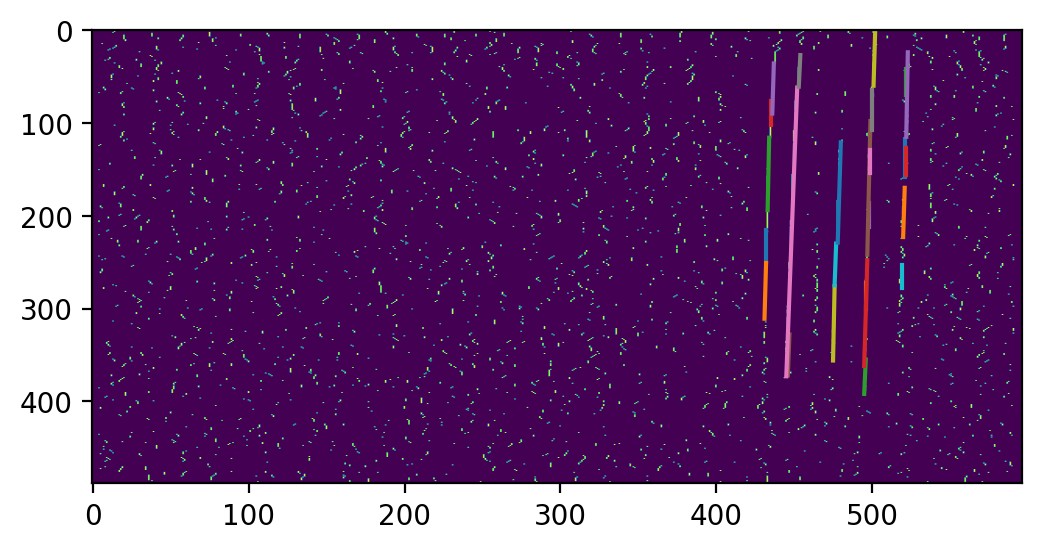

In [8]:
fig,ax = plt.subplots(1,1,figsize=[6,3],dpi=200)
lines = sorted(lines, key=lambda i: i[0][1])
ax.imshow(bmap.T,aspect='auto')
for line in lines:
    p0,p1= line
    ax.plot( (p0[1], p1[1]),(p0[0], p1[0]))


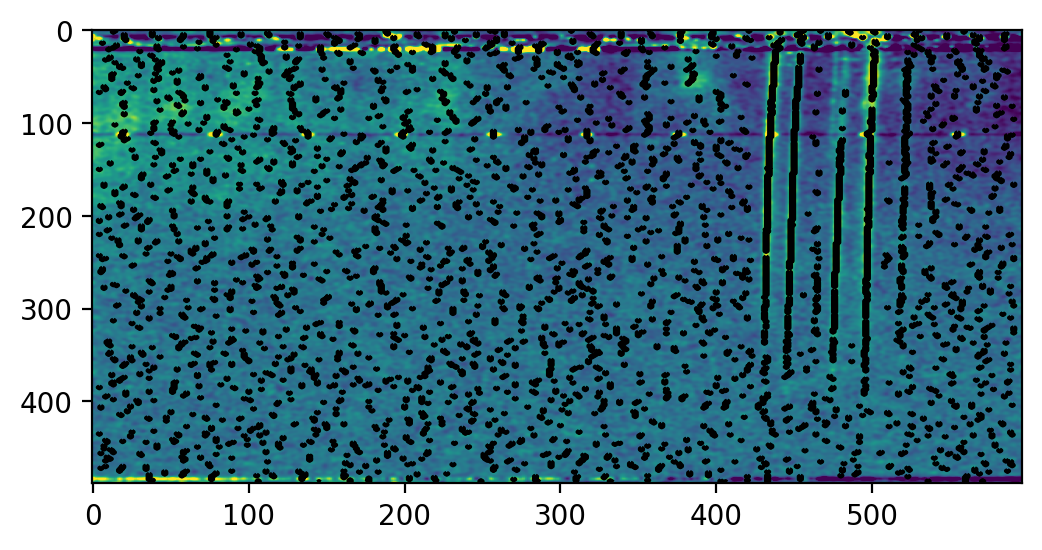

In [9]:
fig = plt.figure(figsize=[6,3],dpi=200)
plt.imshow(data_fits_new.T,aspect='auto',
                   vmin=(np.mean(data_fits_new)-2*np.std(data_fits_new)),
                   vmax=(np.mean(data_fits_new)+3*np.std(data_fits_new)))
plt.contour(bmap.T,[0,0.5,1],colors='k')

#plt.xlim((250,400))

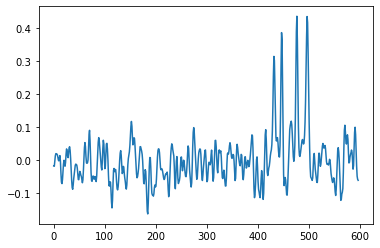

In [10]:
plt.plot(data_fits_new[:,300])

In [11]:
line_sets = drb.line_grouping(lines)
# group the detected lines into group in regard of events

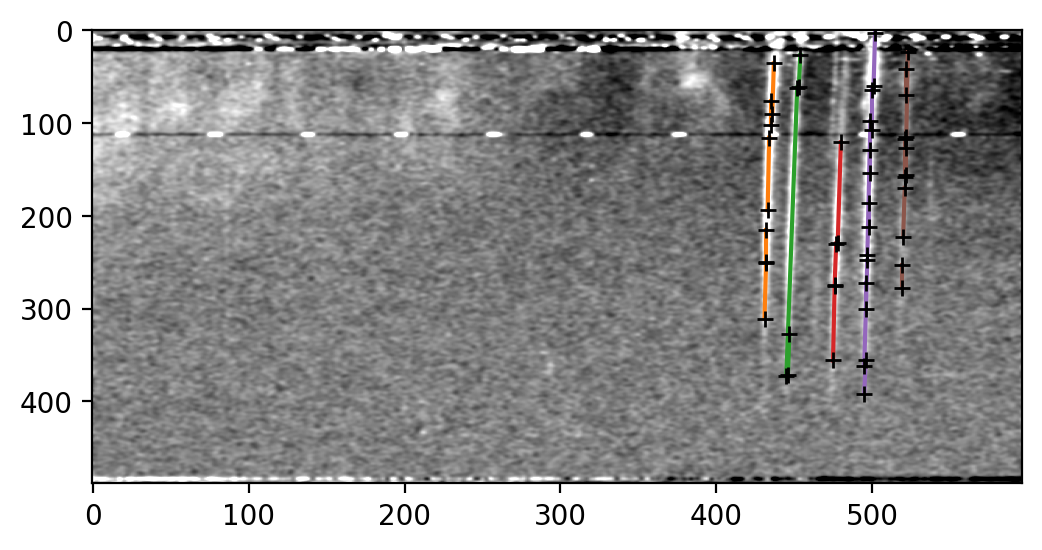

In [12]:
fig,ax = plt.subplots(1,1,figsize=[6,3],dpi=200)
ax.imshow(data_fits_new.T,aspect='auto',
                   vmin=(np.mean(data_fits_new)-2*np.std(data_fits_new)),
                   vmax=(np.mean(data_fits_new)+2*np.std(data_fits_new)),cmap='gray')

for idx,lines in enumerate(line_sets):
    for line in lines:
        p0,p1= line
        ax.plot( (p0[1], p1[1]),(p0[0], p1[0]),color='C'+str(idx+1))
        ax.plot( (p0[1], p1[1]),(p0[0], p1[0]),'k+',zorder=10)
    #ax.set_xlim((500,600))
#ax.set_ylim((bmap.shape[0], 0))

In [13]:
import radioTools as rt

In [14]:
#(rt.freq_to_R(20e6)-rt.freq_to_R(80e6))/rt.c_r

In [60]:
(v_beam, f_range_burst, t_range_burst, model_curve_set,
     t_set_arr_set,f_set_arr_set,t_model_arr,f_model_arr
    )= drb.get_info_from_linegroup(line_sets,t_fits,f_fits)

In [61]:
f_set_arr

array([58.04443359, 61.30371094, 40.30761719, 45.65429688, 47.21679688,
       54.12597656, 30.52978516, 34.1796875 , 41.61376953, 45.38574219,
       28.17382812, 40.0390625 ])

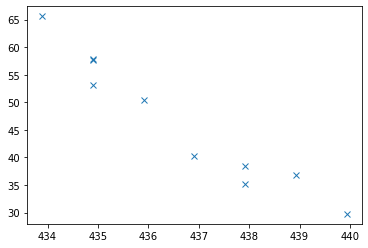

In [62]:
plt.plot(t_set_arr_set[0],f_set_arr_set[0],'x')

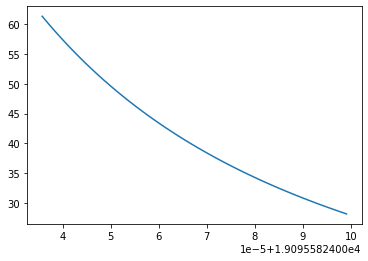

In [18]:
plt.plot(t_model_arr,f_model_arr)

8.227254407523182

In [19]:
line_sets

[[((215, 432), (250, 432)),
  ((251, 432), (311, 431)),
  ((116, 434), (194, 433)),
  ((77, 435), (102, 435)),
  ((36, 437), (90, 436))],
 [((328, 447), (372, 446)), ((62, 452), (373, 445)), ((27, 454), (61, 453))],
 [((276, 476), (356, 475)),
  ((230, 477), (275, 476)),
  ((121, 480), (229, 478))],
 [((272, 496), (300, 496)),
  ((355, 496), (392, 495)),
  ((248, 497), (362, 495)),
  ((186, 498), (212, 498)),
  ((98, 499), (242, 497)),
  ((129, 499), (154, 499)),
  ((65, 500), (108, 500)),
  ((3, 502), (60, 501))],
 [((253, 519), (278, 519)),
  ((117, 521), (158, 521)),
  ((170, 521), (223, 520)),
  ((42, 522), (70, 522)),
  ((127, 522), (156, 522)),
  ((24, 523), (115, 522))]]

Text(0.5, 1.0, '2022/04/13 Radio Flux Intensity LOFAR LBA_OUTER')

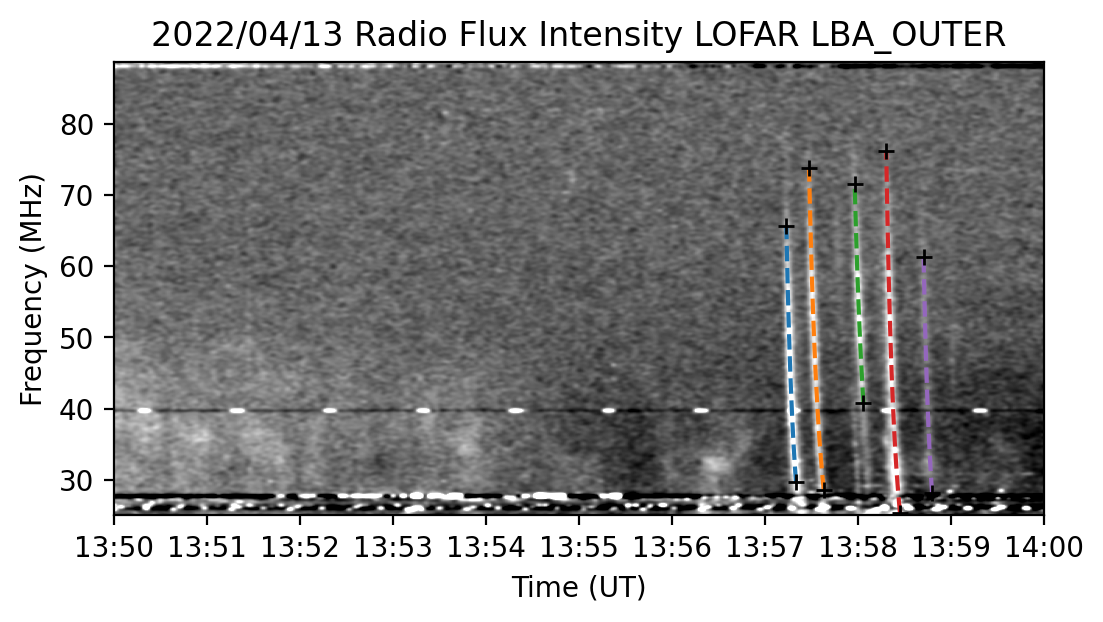

In [20]:
fig,ax = plt.subplots(1,1,figsize=[6,3],dpi=200)
lines = sorted(lines, key=lambda i: i[0][1])
ax.imshow(data_fits_new.T,aspect='auto',origin='lower', 
                   vmin=(np.mean(data_fits_new)-2*np.std(data_fits_new)),
                   vmax=(np.mean(data_fits_new)+3*np.std(data_fits_new)),cmap='gray',
                   extent=[t_fits[0],t_fits[-1],f_fits[0],f_fits[-1]])
for idx,model in enumerate(model_curve_set):
    plt.plot(model[0],model[1],ls='--')
    plt.plot(t_range_burst[idx],f_range_burst[idx],'k+')
    


ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(hdu[0].header['CONTENT'])


#ax.set_xlim([t_fits[200],t_fits[400]])
#plt.ylim([10,88])


In [21]:
# dump information to Json file
import json

In [22]:
fname_json  = fname.replace('.fits','.json')

In [23]:
with open(fname_json, 'r') as fp:
    dict_old = json.load(fp)
    
fp.close()

In [59]:
(t_range_burst[0][1]-t_range_burst[0][0])*3600*24

-6.207548116799444

In [25]:
dict_old

{'telescope': 'LOFAR',
 'instrume': 'LBA_OUTER',
 'projectID': 'LOFAR4SWDevelopement',
 'obsID': '857852',
 'source': './L857852_SAP000_B000_S0_P000_bf.h5',
 'date': '2022-04-13',
 'time': '13:50:00.000000',
 'event': {'detection': True, 'type': 'III', 'level': 'strong'},
 'n_freq': 600,
 'n_time': 597,
 'freq_range': [10.44921875, 88.56201171875],
 'time_range': ['2022-04-13 13:50:00.000000', '2022-04-13 14:00:00.000000']}

In [26]:
event_detail = []
for idx,v_cur in enumerate(v_beam):
    event_detail.append({
        'v_beam':v_cur,
        'freq_range':((f_range_burst[idx])),
        'time_range':((t_range_burst[idx])),
        'str_time':mdates.num2date(t_range_burst[idx][0]).strftime("%H:%M:%S")})

In [27]:
dict_old['event']={
    'detection': True,
    'type':'III',
    'detail': event_detail
}

In [28]:
dict_old

{'telescope': 'LOFAR',
 'instrume': 'LBA_OUTER',
 'projectID': 'LOFAR4SWDevelopement',
 'obsID': '857852',
 'source': './L857852_SAP000_B000_S0_P000_bf.h5',
 'date': '2022-04-13',
 'time': '13:50:00.000000',
 'event': {'detection': True,
  'type': 'III',
  'detail': [{'v_beam': 0.11970411668113957,
    'freq_range': [29.74853515625, 65.6005859375],
    'time_range': [19095.58148281205, 19095.581410965427],
    'str_time': '13:57:20'},
   {'v_beam': 0.09204069146313268,
    'freq_range': [28.564453125, 73.69384765625],
    'time_range': [19095.581690441362, 19095.581580531267],
    'str_time': '13:57:38'},
   {'v_beam': 0.08166609358262836,
    'freq_range': [40.83251953125, 71.47216796875],
    'time_range': [19095.581986642184, 19095.58192140641],
    'str_time': '13:58:03'},
   {'v_beam': 0.11766485550786034,
    'freq_range': [25.439453125, 76.171875],
    'time_range': [19095.582259346065, 19095.582156683136],
    'str_time': '13:58:27'},
   {'v_beam': 0.13873876030742727,
    'fre

In [29]:
with open('test.json', 'w') as fp:
     json.dump(dict_old,fp)
fp.close()

In [74]:
# write all events to a event list

import os
csv_fname = 'event.csv'
os.system('rm '+csv_fname)
id_event  = 0
with open(csv_fname,'w') as fp:
    fp.write('''ID, t, t0_num, t1_num,f_0,f_1, dfdt(MHz/s), v_b(c)
             ''')

with open(csv_fname,'a') as fp:
    
    for idx,v_cur in enumerate(v_beam):
        fp.write(str(id_event)+','+mdates.num2date(t_range_burst[idx][0]).strftime("%y-%m-%d %H:%M:%S")+','
             +str(t_range_burst[idx][0])+','+str(t_range_burst[idx][1])+','
             +str(f_range_burst[idx][0])+','+str(f_range_burst[idx][1])+','
             +str((np.max(f_set_arr_set[idx])-np.min(f_set_arr_set[idx]))/
             (np.max(t_set_arr_set[idx])-np.min(t_set_arr_set[idx])))+','
             +str(v_beam[idx])
             +'''
             ''')
        id_event+=1
fp.close()

In [49]:

os.system('pwd')

1

In [68]:
import glob

In [69]:
glob.glob('L*')

['L857852_SAP000_B000_S0_P000_bf']